#### Image size (30, 32)

- Person class gets the highest accuracy (training: 98%, testing: 95%). However, there is only 1 discrepent images at most.
- With direction of face, the highest accuracy (training: 75%, testing: 77%). However, there are only 7 discrepent images at most.
- With emotions as label, the highest accuracy (training: 32%, testing: 20%).

In [581]:
label_map

{'angry': 0, 'sad': 1, 'neutral': 2, 'happy': 3}

In [582]:
import numpy as np
from mnist import MNIST
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from PIL import Image
from matplotlib import pyplot as plt
from PIL import Image
import os
import seaborn as sns

In [583]:
def read_pgm(pgmf):
    """Return a raster of integers from a PGM as a list of lists."""
    assert pgmf.readline() == b'P5\n'
    (width, height) = [int(i) for i in pgmf.readline().split()]
    depth = int(pgmf.readline())
    assert depth <= 255

    raster = []
    for y in range(height):
        row = []
        for y in range(width):
            row.append(ord(pgmf.read(1)))
        raster.append(row)
    return raster

def make_face_dataset(pix_size="2"):
    face = "./data/faces/"    
    X = []
    y = []
    image_path = []
    for p in os.listdir(face):
        person = face + p
        for img in os.listdir(person):
            if (img.split(".")[1] == "pgm") and (img.split(".")[0][-1] == pix_size):
                img_path = person + '/' + img
                image_path.append(img_path)
                f = open(img_path, 'rb')
                im = read_pgm(f)
                f.close()
                im = np.array(im)
                X.append(im)
                y.append(img.split(".")[0].split("_"))
    image_path = np.array(image_path)
    X = np.array(X)
    y = np.array(y)
    np.save("./data/face_separated/X_Face_" + pix_size + ".npy", X)
    np.save("./data/face_separated/y_Face_" + pix_size + ".npy", y)
    np.save("./data/face_separated/image_path_" + pix_size + ".npy", image_path)

def get_label(y, idx=1):
    y_temp = [item[idx] for item in y]
    label = list(set(y_temp))
    label_map = {label[i]: i for i in range(len(label))}
    y = []
    for item in y_temp:
        y.append(label_map[item])
    
    return np.array(y), label_map

In [586]:
# run this code only once
pix_size = "2"
make_face_dataset(pix_size)

In [587]:
X_face = np.load(f"./data/face_separated/X_face_{pix_size}.npy")
y_face = np.load(f"./data/face_separated/y_face_{pix_size}.npy")
X_train, X_test, y_train, y_test = train_test_split(X_face, y_face, test_size=0.33, random_state=0)
y_train, label_map = get_label(y_train, idx=2)
y_test, _ = get_label(y_test, idx=2)

In [588]:
label_map

{'angry': 0, 'sad': 1, 'neutral': 2, 'happy': 3}

In [589]:
D = 10000 # dimensions in random space
w = X_train[0].shape[0]
h = X_train[0].shape[1]
NUM_SAMPLES = X_train.shape[0]

In [590]:
X_train = np.array([img.flatten() for img in X_train])
X_test = np.array([img.flatten() for img in X_test])

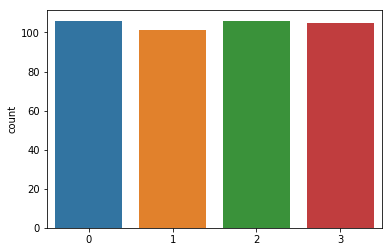

In [591]:
sns.countplot(y_train)

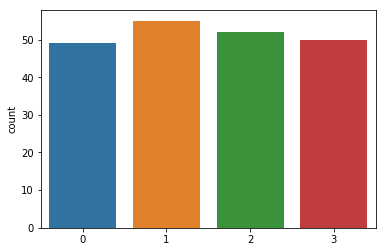

In [592]:
sns.countplot(y_test)

plt.imshow(X_train[2].reshape(28, 28), interpolation='nearest')

img = Image.fromarray(X_train[2].reshape(28, 28))
img.show()

In [593]:
# print("Generating random projection...")
# proj = np.random.rand(D, IMG_LEN * IMG_LEN)
print("Generating random projection...")
seed = 30
np.random.seed(seed)
proj = np.random.rand(D, h * w)
# proj[proj==0] = -1
print(proj.shape)
def get_scene(img, proj):
    return np.dot(proj, img)

# Transform the image vectors into the hypervectors
def get_scenes(images, proj):
    print(images.shape)
    print(proj.shape)
    return np.dot(images[:NUM_SAMPLES, :], proj.T)

print("Projecting images to higher dim space...")
X_train = get_scenes(X_train, proj)

Generating random projection...
(10000, 3840)
Projecting images to higher dim space...
(418, 3840)
(10000, 3840)


In [594]:
digit_vectors = np.zeros((len(label_map), D))
# num_count = {}
for i in range(NUM_SAMPLES):
#     num_count[y_train[i]] =  num_count.get(y_train[i], 0) + 1
    digit_vectors[y_train[i]] += X_train[i]
digit_vectors = np.array(digit_vectors)

In [595]:
# digit_vectors[digit_vectors > 0] = 1
# digit_vectors[digit_vectors <= 0] = -1

for i in num_count:
    digit_vectors[i] /= num_count[i] 

In [596]:
def classify(images, digit_vectors):
    similarities = cosine_similarity(images, digit_vectors)
    classifications = np.argmax(similarities, axis=1)
    return classifications

In [597]:
print("Train accuracy:")
predictions = classify(X_train, digit_vectors)
acc = accuracy_score(y_train[:X_train.shape[0]], predictions)
print(acc)

Train accuracy:
0.33253588516746413


In [598]:
print("Test accuracy:")
X_test = get_scenes(X_test, proj)
predictions = classify(X_test, digit_vectors)
acc = accuracy_score(y_test[:X_test.shape[0]], predictions)
print(acc)

Test accuracy:
(206, 3840)
(10000, 3840)
0.19902912621359223


import pandas as pd
df = pd.DataFrame({f'model_{seed}': predictions,
                   'y': y_train})

In [525]:
np.save(f'./temp/face_digit_vectors_seed_{seed}_version_2_floating.npy', digit_vectors)

#### Make sure you sun from top until this point with multiple seeds to run code below this point

In [526]:
model_30 = np.load("./temp/face_digit_vectors_seed_30_version_2_floating.npy")
model_40 = np.load("./temp/face_digit_vectors_seed_40_version_2_floating.npy")
model_50 = np.load("./temp/face_digit_vectors_seed_50_version_2_floating.npy")

### First, retraining on Adversarial inputs from Training set

In [527]:
X_face = np.load(f"./data/face_separated/X_face_{pix_size}.npy")
y_face = np.load(f"./data/face_separated/y_face_{pix_size}.npy")
X_train, X_test, y_train, y_test = train_test_split(X_face, y_face, test_size=0.33, random_state=0)
y_train, label_map = get_label(y_train, idx=1)
y_test, _ = get_label(y_test, idx=1)
X_train = np.array([img.flatten() for img in X_train])
X_test = np.array([img.flatten() for img in X_test])

In [528]:
import copy
seeds = [30, 40, 50]
models = [model_30, model_40, model_50]
results = []

for seed, model in zip(seeds, models):
    np.random.seed(seed)
    proj = np.random.rand(D, h * w)
#     X_train_copy = copy.deepcopy(X_train)
#     X_train_copy = get_scenes(X_train_copy, proj)
    X_test_copy = copy.deepcopy(X_test)
    X_test_copy = get_scenes(X_test_copy, proj)
    predictions = classify(X_test_copy, model)
    results.append(predictions)
    print("here")

(206, 960)
(10000, 960)
here
(206, 960)
(10000, 960)
here
(206, 960)
(10000, 960)
here


In [529]:
len(results[0])

206

In [530]:
import pandas as pd
df = pd.DataFrame({'model_30': list(results[0]),
                   'model_40': list(results[1]),
                   'model_50': list(results[2]),
                   'y': y_test})

In [531]:
df.head()

,model_30,model_40,model_50,y
0,0,0,0,3
1,3,3,3,2
2,2,2,2,2
3,0,0,0,0
4,2,2,2,2


In [532]:
df_discrepencies = df[(df["model_30"] != df["model_40"]) | (df["model_30"] != df["model_50"]) | (df["model_40"] != df["model_50"])]

In [533]:
df_discrepencies.head()

,model_30,model_40,model_50,y
11,0,1,0,1
14,0,1,0,0
25,0,3,3,2
35,0,0,3,3
53,0,2,2,2


In [45]:
len(df_discrepencies)

631

In [190]:
df_discrepencies.reset_index(inplace=True)

In [191]:
df_discrepencies.head()

,index,model_30,model_40,model_50,y
0,0,7,9,7,8
1,2,4,4,2,9
2,51,9,4,9,4
3,151,0,0,4,7
4,175,9,7,9,7


In [192]:
def get_scene(img, proj):
    return np.dot(img, proj.T)

In [193]:
epochs = 10

for epoch in range(epochs):
    for row in df_discrepencies.iterrows():
        idx = row[1]["index"]
        y_false = row[1]["model_50"]
        y_true = row[1]["y"]
        hv = get_scene(X_train[idx].reshape((1, -1)), proj)
        model_50[y_false] -= hv[0]
        model_50[y_true] += hv[0]

In [71]:
for i, j, k in zip([1, 2, 3], ['a', 'b', 'c'], [4, 5, 6]):
    print(i, j, k)

1 a 4
2 b 5
3 c 6


In [194]:
# print("Generating random projection...")
# proj = np.random.rand(D, IMG_LEN * IMG_LEN)
print("Generating random projection...")
seed = 50
np.random.seed(seed)
proj = np.random.rand(D, IMG_LEN * IMG_LEN)
# proj[proj==0] = -1
print(proj.shape)
def get_scene(img, proj):
    return np.dot(img, proj.T)

# Transform the image vectors into the hypervectors
def get_scenes(images, proj):
    print(images.shape)
    print(proj.shape)
    return np.dot(images[:NUM_SAMPLES, :], proj.T)

print("Projecting images to higher dim space...")
X_train = get_scenes(X_train, proj)

Generating random projection...
(10000, 784)
Projecting images to higher dim space...
(40200, 784)
(10000, 784)


In [195]:
print("Train accuracy:")
predictions = classify(X_train, model_50)
acc = accuracy_score(y_train[:X_train.shape[0]], predictions)
print(acc)

Train accuracy:
0.8420398009950248


In [196]:
print("Test accuracy:")
X_test = get_scenes(X_test, proj)
predictions = classify(X_test, model_50)
acc = accuracy_score(y_test[:X_test.shape[0]], predictions)
print(acc)

Test accuracy:
(19800, 784)
(10000, 784)
0.8433838383838383


In [201]:
test = df[(df["model_30"] == df["model_40"]) & (df["model_30"] == df["model_50"]) & (df["model_40"] == df["model_50"]) ]

In [208]:
1 - len(test[test["model_50"] != test["y"]])/len(df)

0.8320398009950248

In [ ]:
np.save(f'./temp/digit_vectors_seed_{seed}_version_2_floating_retrained.npy', digit_vectors)

In [ ]:
model_30 = np.load("./temp/digit_vectors_seed_30_version_2_floating_retrained.npy")
model_40 = np.load("./temp/digit_vectors_seed_40_version_2_floating_retrained.npy")
model_50 = np.load("./temp/digit_vectors_seed_50_version_2_floating_retrained.npy")

In [ ]:
X_train, labels_train, _, _ = load_dataset()
# X_train, labels_train = shuffle(X_train, labels_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, labels_train, test_size=0.33, random_state=42)

In [ ]:
import copy
seeds = [30, 40, 50]
models = [model_30, model_40, model_50]
results = []

for seed, model in zip(seeds, models):
    np.random.seed(seed)
    proj = np.random.rand(D, IMG_LEN * IMG_LEN)
    X_train_copy = copy.deepcopy(X_train)
    X_train_copy = get_scenes(X_train_copy, proj)
    predictions = classify(X_train_copy, model)
    results.append(predictions)
    print("here")

In [49]:
X_train, labels_train, _, _ = load_dataset()
# X_train, labels_train = shuffle(X_train, labels_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, labels_train, test_size=0.33, random_state=42)

In [23]:
import copy
seeds = [30, 40, 50]
models = [model_30, model_40, model_50]
results = []

for seed, model in zip(seeds, models):
    np.random.seed(seed)
    proj = np.random.rand(D, IMG_LEN * IMG_LEN)
    X_test_copy = copy.deepcopy(X_test)
    X_test_copy = get_scenes(X_test_copy, proj)
    predictions = classify(X_test_copy, model)
    results.append(predictions)
    print("here")

NameError: name 'get_scenes' is not defined

In [49]:
np.save("./temp/results_30_40_50_version_2.npy", results)

In [4]:
results = np.load("./temp/results_30_40_50_version_2.npy")

In [5]:
import pandas as pd
df = pd.DataFrame({'model_30': list(results[0]),
                   'model_40': list(results[1]),
                   'model_50': list(results[2]),
                   'y': y_test})

In [6]:
df.head()

,model_30,model_40,model_50,y
0,7,7,7,7
1,3,3,3,3
2,8,8,8,8
3,9,9,9,9
4,3,3,3,3


In [7]:
len(df)

19800

In [8]:
df_discrepencies = df[(df["model_30"] != df["model_40"]) | (df["model_30"] != df["model_50"]) | (df["model_40"] != df["model_50"])]

In [9]:
df_discrepencies.to_excel("./temp/test_discrepencies_version_2_floating.xlsx")

df_discrepencies = df[(df["y"] == df["model_30"]) | (df["y"] == df["model_40"]) | (df["y"] == df["model_50"])]

df_discrepencies = df_discrepencies[((df_discrepencies["y"] + df_discrepencies["model_30"]
                                     + df_discrepencies["model_40"] + df_discrepencies["model_50"]) 
                                     != df_discrepencies["y"] * 4)]

df_discrepencies.head()

sum(df_discrepencies["model_50"] != df_discrepencies["y"])

len(df_discrepencies)

df_discrepencies.to_excel("./temp/test_discrepencies_version_2.xlsx")

test_discrepencies = pd.read_excel("./temp/test_discrepencies_version_2.xlsx")

In [10]:
len(df_discrepencies)

631

In [11]:
df_discrepencies.head()

,model_30,model_40,model_50,y
15,9,7,9,7
29,2,6,2,6
64,5,0,5,0
83,1,1,7,9
102,5,5,8,5


In [60]:
test_discrepencies.rename(columns={"Unnamed: 0": "idx"}, inplace=True)

In [61]:
test_discrepencies.head()

,idx,model_30,model_40,model_50,y
0,15,9,7,9,7
1,29,2,6,2,6
2,64,5,0,5,0
3,102,5,5,8,5
4,173,9,7,9,9


In [62]:
def get_scene(img, proj):
    return np.dot(img, proj.T)

In [63]:
for row in test_discrepencies.iterrows():
    idx = row[1]["idx"]
    y_false = row[1]["model_30"]
    y_true = row[1]["y"]
    hv = get_scene(X_train[idx].reshape((1, -1)), proj)
    model_30[y_false] -= hv[0]
    model_30[y_true] += hv[0]

In [64]:
# print("Generating random projection...")
# proj = np.random.rand(D, IMG_LEN * IMG_LEN)
print("Generating random projection...")
seed = 30
np.random.seed(seed)
proj = np.random.rand(D, IMG_LEN * IMG_LEN)
# proj[proj==0] = -1
print(proj.shape)
def get_scene(img, proj):
    return np.dot(img, proj.T)

# Transform the image vectors into the hypervectors
def get_scenes(images, proj):
    print(images.shape)
    print(proj.shape)
    return np.dot(images[:NUM_SAMPLES, :], proj.T)

print("Projecting images to higher dim space...")
X_train = get_scenes(X_train, proj)

Generating random projection...
(10000, 784)
Projecting images to higher dim space...
(40200, 784)
(10000, 784)


In [65]:
print("Train accuracy:")
predictions = classify(X_train, model_30)
acc = accuracy_score(y_train[:X_train.shape[0]], predictions)
print(acc)

Train accuracy:
0.8130597014925374


In [66]:
print("Test accuracy:")
X_test = get_scenes(X_test, proj)
predictions = classify(X_test, model_30)
acc = accuracy_score(y_test[:X_test.shape[0]], predictions)
print(acc)

Test accuracy:
(19800, 784)
(10000, 784)
0.8077272727272727
